In [93]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

### CSV to DataFrame

In [94]:
df = pd.read_csv("/Users/suchan/study/파이널 프로젝트/0425_KOR_final_drama_reviews.csv")

### 전처리 함수

In [95]:
import re
from konlpy.tag import Mecab
from tqdm import tqdm

In [96]:
def clean_text(text):
    text = text.replace(".", "").strip()
    text = text.replace("·", " ").strip()
    pattern = '[^ ㄱ-ㅣ가-힣|0-9]+'
    text = re.sub(pattern, '', text)
    return text

def get_nouns(tokenizer, sentence):
    tagged = tokenizer.pos(sentence)
    stop_words = ['드라마', '정도', '사람', '생각', '여자', '남자', '에피소드', '시리즈', '자신', '최고', '완벽', '시즌', '느낌', '기대',
                  '넷플릭스', '장르', '부분', '내용', '시간']
    nouns = [word for word, tag in tagged if tag in ['NNG', 'NNP'] and len(word) >1 and word not in stop_words]
    return nouns

def tokenize(df):
    tokenizer = Mecab()
    processed_data = []
    for sent in tqdm(df['reviews']):
        sentence = clean_text(str(sent).replace("\n", "").strip())
        processed_data.append(get_nouns(tokenizer, sentence))
    return processed_data

### 전처리 실행

In [98]:
preprocessed_data = tokenize(df)

100%|██████████| 63011/63011 [00:08<00:00, 7835.56it/s]


In [99]:
df['preprocessed_reviews'] = preprocessed_data

In [100]:
df['preprocessed_reviews']

0                             [캐스팅, 라인업, 노희경, 극본, 몰입, 차승원]
1                                    [침묵, 순간, 노희경, 극본, 경지]
2                                   [세상, 노희경, 작가, 배우, 스토리]
3                                         [배우, 한수, 위험, 고통]
4                                            [특별, 저마다, 사정]
                               ...                        
63006    [종교, 재료, 집단, 자살, 사건, 쇼킹, 무당, 소재, 순간, 답지, 문제, 기...
63007    [김단, 천재인, 캐릭터, 이용, 단편, 매력, 연계, 주요, 갈등, 맥락, 상대,...
63008                      [흥미, 중반, 완성도, 후반, 마지막, 아빠, 피해자]
63009                                 [대본, 연출, 연기, 모두, 부족]
63010                               [국판, 데스노트, 천재, 심리, 싸움]
Name: preprocessed_reviews, Length: 63011, dtype: object

### LDA

In [101]:
import gensim
from gensim import corpora
from gensim.models.ldamodel import LdaModel

In [102]:
dictionary = corpora.Dictionary(df['preprocessed_reviews'])
dictionary.filter_extremes(no_below=20, no_above=0.5)

In [103]:
corpus = [dictionary.doc2bow(text) for text in df['preprocessed_reviews']]

In [104]:
temp = dictionary[0]
id2word = dictionary.id2token

#### 토픽 갯수 몇개로 할지 판단

In [105]:
from gensim.models.coherencemodel import CoherenceModel
import matplotlib.pyplot as plt

In [107]:
num_topics = 4
chunksize = 2000
passes = 40
iterations = 250
eval_every = 1
random_state = None

coherence = []
for k in range(3,10):
    print('토픽 갯수: '+str(k))
    Lda = gensim.models.ldamodel.LdaModel
    lda = Lda(corpus, num_topics=k, id2word=id2word, passes=passes,
              iterations=iterations, chunksize=chunksize, eval_every=eval_every, random_state=random_state)

    cm = gensim.models.coherencemodel.CoherenceModel(lda, texts=preprocessed_data,
                                                     dictionary=dictionary, coherence='c_v')
    coherence.append((k, cm.get_coherence()))

토픽 갯수: 3
토픽 갯수: 4
토픽 갯수: 5
토픽 갯수: 6
토픽 갯수: 7
토픽 갯수: 8
토픽 갯수: 9


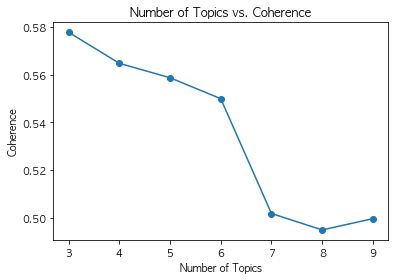

In [108]:
x_val = [x[0] for x in coherence]
y_val = [x[1] for x in coherence]

plt.plot(x_val,y_val)
plt.scatter(x_val,y_val)
plt.title('Number of Topics vs. Coherence')
plt.xlabel('Number of Topics')
plt.ylabel('Coherence')
plt.xticks(x_val)
plt.show()

#### LDA 실행

In [111]:
num_topics = 4
chunksize = 2000
passes = 40
iterations = 250
eval_every = 1
random_state = None

Lda = gensim.models.ldamodel.LdaModel
lda = Lda(corpus, num_topics=num_topics, id2word=id2word, passes=passes,
          iterations=iterations, chunksize=chunksize, eval_every=eval_every, random_state=None)
lda.show_topics(4, num_words=20, formatted=False)

[(0,
  [('인간', 0.028131735),
   ('현실', 0.022720514),
   ('사회', 0.017361032),
   ('세상', 0.013433115),
   ('지옥', 0.013176562),
   ('경찰', 0.013078987),
   ('세계', 0.011024164),
   ('문제', 0.009883308),
   ('폭력', 0.0080259275),
   ('사건', 0.007512863),
   ('이유', 0.0073538497),
   ('게임', 0.006671157),
   ('오징어', 0.0064946064),
   ('존재', 0.0064307284),
   ('범죄', 0.0064226245),
   ('종교', 0.0063693183),
   ('정의', 0.0058202897),
   ('모습', 0.005625828),
   ('상황', 0.0050816764),
   ('정치', 0.0050568036)]),
 (1,
  [('캐릭터', 0.020735301),
   ('작품', 0.018252427),
   ('한국', 0.015060596),
   ('전개', 0.014242265),
   ('소재', 0.013837546),
   ('장면', 0.013822277),
   ('결말', 0.013721775),
   ('부분', 0.01358833),
   ('연출', 0.013270726),
   ('마지막', 0.013071832),
   ('설정', 0.012877828),
   ('영화', 0.012422448),
   ('이야기', 0.012010449),
   ('인물', 0.0099126315),
   ('스토리', 0.0098557025),
   ('초반', 0.009445295),
   ('게임', 0.008908606),
   ('주인공', 0.008758819),
   ('감독', 0.008447431),
   ('대사', 0.008299787)]),
 (2,
  [('

#### 시각화

In [24]:
import pyLDAvis.gensim_models as gensimvis
import pyLDAvis

In [112]:
pyLDAvis.enable_notebook()
vis = gensimvis.prepare(lda, corpus, dictionary)
pyLDAvis.display(vis)

#### 문서별 토픽 비중 보기

In [113]:
for i, topic_list in enumerate(lda[corpus]):
    if i==5:
        break
    print(f'{i+1}번째 문서의 topic 비율은',topic_list)

1번째 문서의 topic 비율은 [(0, 0.04167105), (1, 0.04235725), (2, 0.87430066), (3, 0.041671038)]
2번째 문서의 topic 비율은 [(0, 0.20786202), (1, 0.041981585), (2, 0.5417774), (3, 0.20837902)]
3번째 문서의 topic 비율은 [(0, 0.20616612), (1, 0.042307526), (2, 0.70765615), (3, 0.043870218)]
4번째 문서의 topic 비율은 [(0, 0.4482781), (1, 0.050009847), (2, 0.44996583), (3, 0.051746268)]
5번째 문서의 topic 비율은 [(0, 0.3124023), (1, 0.06371095), (2, 0.062523164), (3, 0.5613636)]


In [114]:
def make_topictable_per_doc(lda, corpus):
    topic_table = pd.DataFrame()

    # 몇 번째 문서인지를 의미하는 문서 번호와 해당 문서의 토픽 비중을 한 줄씩 꺼내온다.
    for i, topic_list in enumerate(lda[corpus]):
        doc = topic_list[0] if lda.per_word_topics else topic_list            
        doc = sorted(doc, key=lambda x: (x[1]), reverse=True)
        # 각 문서에 대해서 비중이 높은 토픽순으로 토픽을 정렬한다.
        # EX) 정렬 전 0번 문서 : (2번 토픽, 48.5%), (8번 토픽, 25%), (10번 토픽, 5%), (12번 토픽, 21.5%), 
        # Ex) 정렬 후 0번 문서 : (2번 토픽, 48.5%), (8번 토픽, 25%), (12번 토픽, 21.5%), (10번 토픽, 5%)
        # 48 > 25 > 21 > 5 순으로 정렬이 된 것.

        # 모든 문서에 대해서 각각 아래를 수행
        for j, (topic_num, prop_topic) in enumerate(doc): #  몇 번 토픽인지와 비중을 나눠서 저장한다.
            if j == 0:  # 정렬을 한 상태이므로 가장 앞에 있는 것이 가장 비중이 높은 토픽
                topic_table = topic_table.append(pd.Series([int(topic_num), round(prop_topic,4), topic_list]), ignore_index=True)
                # 가장 비중이 높은 토픽과, 가장 비중이 높은 토픽의 비중과, 전체 토픽의 비중을 저장한다.
            else:
                break
    return(topic_table)

In [ ]:
topictable = make_topictable_per_doc(lda, corpus)
topictable = topictable.reset_index() # 문서 번호을 의미하는 열(column)로 사용하기 위해서 인덱스 열을 하나 더 만든다.
topictable.columns = ['문서 번호', '가장 비중이 높은 토픽', '가장 높은 토픽의 비중', '각 토픽의 비중']

In [ ]:
topictable[:30]

#### unseen_doc

In [89]:
for i in tqdm(range(len(corpus))):
    review = corpus[i]
    vector = lda[review]
    vec_dict['review_num'].append(i)
    vec_dict['vec'].append(vector)

ValueError: too many values to unpack (expected 2)

In [88]:
vec[:10]

[[(0, 0.035952475), (1, 0.58964294), (2, 0.33844653), (3, 0.035958026)],
 [(0, 0.3663324), (1, 0.37435037), (2, 0.2145099), (3, 0.044807304)],
 [(0, 0.20840017), (1, 0.3978236), (2, 0.35210657), (3, 0.0416696)],
 [(0, 0.45017752), (1, 0.25023583), (2, 0.24956174), (3, 0.050024893)],
 [(0, 0.79438496), (1, 0.06490525), (2, 0.07818313), (3, 0.062526666)],
 [(0, 0.27144465), (1, 0.32383448), (2, 0.35154337), (3, 0.053177495)],
 [(0, 0.58966476), (1, 0.018051755), (2, 0.23141775), (3, 0.16086574)],
 [(0, 0.61601776), (1, 0.05140504), (2, 0.050522055), (3, 0.2820552)],
 [(0, 0.09945148), (1, 0.25133044), (2, 0.63241756), (3, 0.016800508)],
 [(0, 0.0768523), (1, 0.47920716), (2, 0.33585683), (3, 0.10808371)]]